<a href="https://colab.research.google.com/github/annajli/composite_gps_map/blob/main/%5BFINAL%5D_Type_II_MAP_for_Composite_GPs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Type-II MAP Method for Gaussian Process Regression
---
We implement the Pymc3 GP package to compare three methods for hyperparameter tuning for Gaussian Process Regression.

PyMC3 GP Introduction: https://pymc3-testing.readthedocs.io/en/rtd-docs/notebooks/GP-introduction.html

PyMC3 GP Noisy Model Implementation (Implemented in this Notebook): https://docs.pymc.io/notebooks/GP-Marginal.html

GPFlow Fully Bayesian Code: https://gpflow.readthedocs.io/en/master/notebooks/advanced/mcmc.html#Example-3:-Fully-Bayesian-inference-for-generalized-GP-models-with-HMC

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pymc3 as pm
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
!pip install tensorflow
import tensorflow as tf
!pip install gpflow
import gpflow
import tensorflow_probability as tfp
from gpflow.utilities import print_summary, to_default_float, set_trainable
from gpflow.ci_utils import ci_niter
# convert to float64 for tfp to play nicely with gpflow in 64
f64 = gpflow.utilities.to_default_float

In [3]:
print(gpflow.__version__)

2.2.1


In [4]:
def execute_gp_inference(model, x_test, num_samples=100):
  ## predict mean and variance of latent GP at test points
  mean, var = model.predict_f(x_test)

  ## generate 100 samples from posterior
  tf.random.set_seed(1)  # for reproducibility
  samples = model.predict_f_samples(x_test, num_samples)  # shape (10, 100, 1)

  return mean, var, samples

In [5]:
# plotting utility function
# model is a GPyflow model object
# X_train, y_train are the training data
# x_test is the grid at which we predict on 
# test_idx are the indices of x_test that we calculate RMSE against y_val
def plot_model_prediction(model, X_train, y_train, x_test, test_idx, y_val, title=None, pdf_name=None):
  # inference
  mean, var, samples = execute_gp_inference(model, x_test, num_samples=10)

  ## plot
  plt.figure(figsize=(7, 5))
  # plot predictions
  plt.plot(x_test, mean, "C0", lw=2)
  plt.fill_between(
      x_test.flatten(),
      mean[:, 0] - 2 * np.sqrt(var[:, 0]),
      mean[:, 0] + 2 * np.sqrt(var[:, 0]),
      color="C0",
      alpha=0.2,
  )

  # plot training data
  plt.plot(X_train, y_train, "kx", mew=2, color='black')
  # plot test data
  plt.plot(x_test[test_idx], y_val, "kx", mew=2, color='#94d2eb')
  plt.title(title)

  if pdf_name is None:
    plt.show()
  else: 
    plt.savefig(pdf_name, bbox_inches='tight')
    # files.download(pdf_name)

    plt.show()

## Complex Kernels
---

### Generating Kernel
---

In [6]:
# Define the true covariance function and its parameters
# SE 
l_se_true = 1.0
sig_ard_true = 3.0
# Periodic
period_true = 0.6
l_per_true = 0.4
# Rational Quadratic
alpha_true = 0.1
l_rq_true = 0.2
tau_true = 2.0
# White Noise
noise_true = 2.0

# SE ARD Kernel
ls_true = np.array([0.2, 1.0])
arc_cov = sig_ard_true ** 2 * pm.gp.cov.ExpQuad(input_dim=2, ls=ls_true)

# Complex Composite Kernel
k_se = sig_ard_true ** 2 * pm.gp.cov.ExpQuad(1, l_se_true)
k_per = sig_ard_true ** 2 * pm.gp.cov.Periodic(1, period=period_true, ls=l_per_true)
k_RQ = tau_true * pm.gp.cov.RatQuad(1, l_rq_true, alpha_true)
k_noise = pm.gp.cov.WhiteNoise(noise_true)
composite_cov = k_se + k_se * k_per + k_RQ + k_se + k_noise

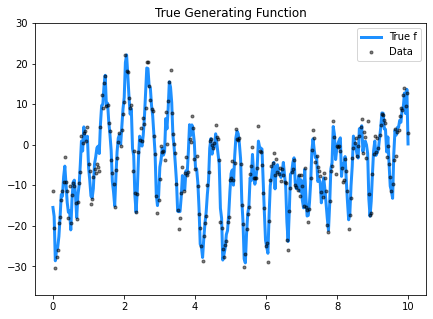

In [7]:
np.random.seed(1)
n = 300  # The number of data points
X = np.linspace(0, 10, n)[:, None].reshape(-1, 1)  # The inputs to the GP, they must be arranged as a column vector

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC3 built on top of Theano
f_true = np.random.multivariate_normal(
    mean_func(X).eval(), composite_cov(X).eval() + 1e-8 * np.eye(n), 1
).flatten()

# The observed data is the latent function plus a small amount of IID Gaussian noise
# The standard deviation of the noise is `sigma`
sigma_true = 2.0
y = f_true + sigma_true * np.random.randn(n)
y = y.reshape(-1, 1)

## Plot the data and the unobserved latent function
fig = plt.figure(figsize=(7, 5))
ax = fig.gca()
ax.plot(X, f_true, "dodgerblue", lw=3, label="True f")
ax.plot(X, y, "ok", ms=3, alpha=0.5, label="Data")
# ax.set_xlabel("X")
# ax.set_ylabel("The true f(x)")
plt.ylim(-37, 30)
ax.set_title('True Generating Function')
plt.legend()
plt.savefig('sim_true_function.pdf', bbox_inches='tight')

In [8]:
# train split and test split
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
train_idx, test_idx = sklearn.model_selection.train_test_split(range(n), test_size=0.5, random_state=1)
X_sim_train = X[train_idx].reshape(-1, 1)
y_sim_train = y[train_idx].reshape(-1, 1)
X_sim_test = X[test_idx].reshape(-1, 1)
y_sim_test = y[test_idx].reshape(-1, 1)

### Hyperparamter Optimization Schemes
---

#### MLE
---

In [10]:
# defining kernel
k_1 = gpflow.kernels.SquaredExponential()
k_2 = gpflow.kernels.Periodic(gpflow.kernels.SquaredExponential())
k_3 = gpflow.kernels.RationalQuadratic()
k_mle = k_1 + k_1 * k_2 + k_3 + k_1

# defining the model
# note: X, y data need to be reshaped to 2 dimensional (n, 1) to have correct inference
mle_model = gpflow.models.GPR((X_sim_train, y_sim_train), kernel=k_mle)

# GPflow maximizes the log marginal likelihood by minimizing the training loss
# docs: https://gpflow.readthedocs.io/en/master/notebooks/basics/regression.html
# note: likelihood.variance is the noise variance of the Gaussian white noise model
opt = gpflow.optimizers.Scipy()
opt.minimize(mle_model.training_loss, variables=mle_model.trainable_variables, options=dict(maxiter=1000))
print_summary(mle_model)

╒═══════════════════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════════╕
│ name                                                      │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │        value │
╞═══════════════════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════════╡
│ GPR.kernel.kernels[0].variance                            │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 63.5364      │
│ GPR.kernel.kernels[1].kernels[0].variance                 │           │                  │         │             │         │         │              │
│ GPR.kernel.kernels[3].variance                            │           │                  │         │             │         │         │              │
├───────────────────────────────────────────────────────────┼───────────┼───────────────

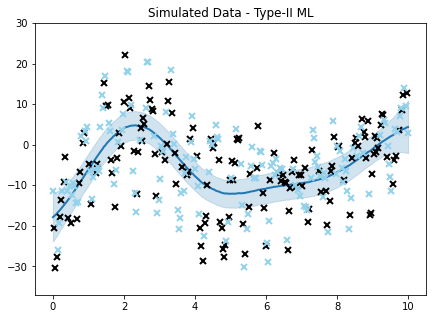

In [12]:
# inference
mean, var, _ = execute_gp_inference(mle_model, X, num_samples=10)

## plot
plt.figure(figsize=(7, 5))
# plot predictions
plt.plot(X, mean, "C0", lw=2)
plt.fill_between(
      X.flatten(),
      mean[:, 0] - 2 * np.sqrt(var[:, 0]),
      mean[:, 0] + 2 * np.sqrt(var[:, 0]),
      color="C0",
      alpha=0.2,
)
  
# plot training data
plt.plot(X_sim_train, y_sim_train, "kx", mew=2, color='black')
# plot test data
plt.plot(X_sim_test, y_sim_test, "kx", mew=2, color='#94d2eb')
plt.title('Simulated Data - Type-II ML')
plt.ylim(-37, 30)
plt.savefig('sim_mle.pdf', bbox_inches='tight')

plt.show()

In [ ]:
lml = mle_model.log_marginal_likelihood().numpy()
rms = mean_squared_error(mean.numpy().flatten()[test_idx], y_sim_test, squared=False)
print("LML: {}".format(lml))
print("RMSE: {}".format(rms))

LML: -542.6552556728332
RMSE: 8.641243404115757


#### MAP
---

In [13]:
prior_var = 1.0
# defining kernel
# SE
k_1 = gpflow.kernels.SquaredExponential()
# SE priors
k_1.variance.prior = tfp.distributions.LogNormal(to_default_float(0), to_default_float(prior_var))
k_1.lengthscales.prior = tfp.distributions.LogNormal(to_default_float(0), to_default_float(prior_var))
# PER 
k_2 = gpflow.kernels.Periodic(gpflow.kernels.SquaredExponential())
# PER priors
k_2.base_kernel.variance.prior = tfp.distributions.LogNormal(to_default_float(0), to_default_float(prior_var))
k_2.base_kernel.lengthscales.prior = tfp.distributions.LogNormal(to_default_float(0), to_default_float(prior_var))
k_2.period.prior = tfp.distributions.LogNormal(to_default_float(0), to_default_float(prior_var))
# RQ
k_3 = gpflow.kernels.RationalQuadratic()
# RQ priors
k_3.variance.prior = tfp.distributions.LogNormal(to_default_float(0), to_default_float(prior_var))
k_3.lengthscales.prior = tfp.distributions.LogNormal(to_default_float(0), to_default_float(prior_var))
k_3.alpha.prior = tfp.distributions.LogNormal(to_default_float(0), to_default_float(prior_var))
# composite
k_map = k_1 + k_1 * k_2 + k_3 + k_1

# defining the model
map_model = gpflow.models.GPR((X_sim_train, y_sim_train), kernel=k_map)
map_model.likelihood.variance.prior = tfp.distributions.LogNormal(to_default_float(0), to_default_float(3))

# GPflow maximizes the log marginal likelihood by minimizing the training loss
# docs: https://gpflow.readthedocs.io/en/master/notebooks/basics/regression.html
# note: likelihood.variance is the noise variance of the Gaussian white noise model
opt = gpflow.optimizers.Scipy()
opt.minimize(map_model.training_loss, variables=map_model.trainable_variables, options=dict(maxiter=1000))
print_summary(map_model)

╒═══════════════════════════════════════════════════════════╤═══════════╤══════════════════╤═══════════╤═════════════╤═════════╤═════════╤════════════╕
│ name                                                      │ class     │ transform        │ prior     │ trainable   │ shape   │ dtype   │      value │
╞═══════════════════════════════════════════════════════════╪═══════════╪══════════════════╪═══════════╪═════════════╪═════════╪═════════╪════════════╡
│ GPR.kernel.kernels[0].variance                            │ Parameter │ Softplus         │ LogNormal │ True        │ ()      │ float64 │  3.49967   │
│ GPR.kernel.kernels[1].kernels[0].variance                 │           │                  │           │             │         │         │            │
│ GPR.kernel.kernels[3].variance                            │           │                  │           │             │         │         │            │
├───────────────────────────────────────────────────────────┼───────────┼───────────────

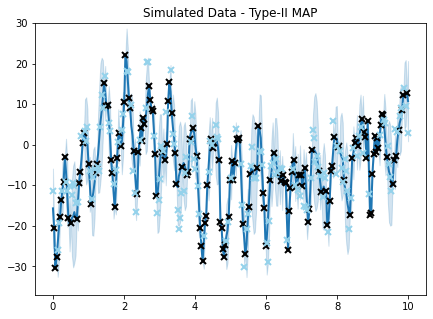

In [14]:
# inference
mean, var, _ = execute_gp_inference(map_model, X, num_samples=10)

## plot
plt.figure(figsize=(7, 5))
# plot predictions
plt.plot(X, mean, "C0", lw=2)
plt.fill_between(
      X.flatten(),
      mean[:, 0] - 2 * np.sqrt(var[:, 0]),
      mean[:, 0] + 2 * np.sqrt(var[:, 0]),
      color="C0",
      alpha=0.2,
)
  
# plot training data
plt.plot(X_sim_train, y_sim_train, "kx", mew=2, color='black')
# plot test data
plt.plot(X_sim_test, y_sim_test, "kx", mew=2, color='#94d2eb')
plt.title('Simulated Data - Type-II MAP')
plt.ylim(-37, 30)
plt.savefig('sim_map.pdf', bbox_inches='tight')

plt.show()

In [15]:
lml = map_model.log_marginal_likelihood().numpy()
rms = mean_squared_error(mean.numpy().flatten()[test_idx], y_sim_test, squared=False)
print("LML: {}".format(lml))
print("RMSE: {}".format(rms))

LML: -498.771425652571
RMSE: 4.3917455689327385


#### Fully Bayesian Model
---

In [16]:
# defining the model
# full model uses the same kernel structure and priors and k_map
full_model = gpflow.models.GPR((X_sim_train, y_sim_train), kernel=k_map)
full_model.likelihood.variance.prior = tfp.distributions.LogNormal(to_default_float(0), to_default_float(3))

# GPflow maximizes the log marginal likelihood by minimizing the training loss
# docs: https://gpflow.readthedocs.io/en/master/notebooks/basics/regression.html
# note: likelihood.variance is the noise variance of the Gaussian white noise model
opt = gpflow.optimizers.Scipy()
opt.minimize(full_model.training_loss, variables=full_model.trainable_variables, options=dict(maxiter=100))
print_summary(full_model)

╒═══════════════════════════════════════════════════════════╤═══════════╤══════════════════╤═══════════╤═════════════╤═════════╤═════════╤══════════════╕
│ name                                                      │ class     │ transform        │ prior     │ trainable   │ shape   │ dtype   │        value │
╞═══════════════════════════════════════════════════════════╪═══════════╪══════════════════╪═══════════╪═════════════╪═════════╪═════════╪══════════════╡
│ GPR.kernel.kernels[0].variance                            │ Parameter │ Softplus         │ LogNormal │ True        │ ()      │ float64 │ 12.7948      │
│ GPR.kernel.kernels[1].kernels[0].variance                 │           │                  │           │             │         │         │              │
│ GPR.kernel.kernels[3].variance                            │           │                  │           │             │         │         │              │
├───────────────────────────────────────────────────────────┼───────────┼───

In [17]:
num_burnin_steps = ci_niter(300)
num_samples = ci_niter(500)

def run_hmc_sampler(model):

  # Note that here we need model.trainable_parameters, not trainable_variables - only parameters can have priors!
  hmc_helper = gpflow.optimizers.SamplingHelper(
      full_model.log_posterior_density, full_model.trainable_parameters
  )

  hmc = tfp.mcmc.HamiltonianMonteCarlo(
      target_log_prob_fn=hmc_helper.target_log_prob_fn, num_leapfrog_steps=10, step_size=0.01
  )
  adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
      hmc, num_adaptation_steps=10, target_accept_prob=f64(0.75), adaptation_rate=0.1
  )


  @tf.function
  def run_chain_fn():
      return tfp.mcmc.sample_chain(
          num_results=num_samples,
          num_burnin_steps=num_burnin_steps,
          current_state=hmc_helper.current_state,
          kernel=adaptive_hmc,
          trace_fn=lambda _, pkr: pkr.inner_results.is_accepted,
      )


  samples, traces = run_chain_fn()
  
  return samples, traces

In [18]:
samples, traces = run_hmc_sampler(full_model)

In [19]:
print_summary(full_model)

╒═══════════════════════════════════════════════════════════╤═══════════╤══════════════════╤═══════════╤═════════════╤═════════╤═════════╤══════════════╕
│ name                                                      │ class     │ transform        │ prior     │ trainable   │ shape   │ dtype   │        value │
╞═══════════════════════════════════════════════════════════╪═══════════╪══════════════════╪═══════════╪═════════════╪═════════╪═════════╪══════════════╡
│ GPR.kernel.kernels[0].variance                            │ Parameter │ Softplus         │ LogNormal │ True        │ ()      │ float64 │ 13.0458      │
│ GPR.kernel.kernels[1].kernels[0].variance                 │           │                  │           │             │         │         │              │
│ GPR.kernel.kernels[3].variance                            │           │                  │           │             │         │         │              │
├───────────────────────────────────────────────────────────┼───────────┼───

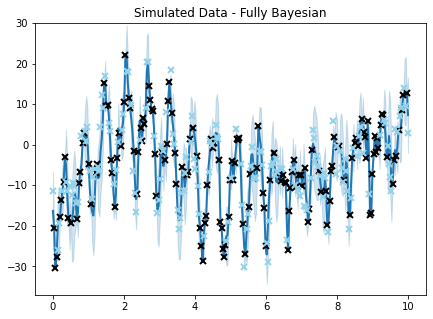

In [20]:
## plot
plt.figure(figsize=(7, 5))

tf.random.set_seed(1)  # for reproducibility
mean, var = full_model.predict_f(X)

# plot predictions
plt.plot(X, mean, "", color='C0', lw=2)
plt.fill_between(
    X.flatten(),
    mean[:, 0] - 2 * np.sqrt(var[:, 0]),
    mean[:, 0] + 2 * np.sqrt(var[:, 0]),
    color='C0',
    alpha=0.2,
)

# plot training data
plt.plot(X_sim_train, y_sim_train, "kx", mew=2, color='black')
# plot test data
plt.plot(X_sim_test, y_sim_test, "kx", mew=2, color='#94d2eb')
plt.title('Simulated Data - Fully Bayesian')
plt.ylim(-37, 30)
plt.savefig('sim_fully_bayes.pdf', bbox_inches='tight')

plt.show()

In [21]:
lml = full_model.log_marginal_likelihood().numpy()
rms = mean_squared_error(mean.numpy().flatten()[test_idx], y_sim_test, squared=False)
print("LML: {}".format(lml))
print("RMSE: {}".format(rms))

LML: -454.6729234741183
RMSE: 4.015847871119945


## Airline Dataset
---

#### Type-II MLE

In [ ]:
# defining the model
mle_model = gpflow.models.GPR((X_air[:train_air_split].reshape(-1, 1), y_air[:train_air_split].reshape(-1, 1)), kernel=k_air)
# mle_model.likelihood.variance = mle_model.kernel.kernels[2].variance
# mle_model.likelihood.variance.assign(1.0)
# gpflow.set_trainable(mle_model.likelihood.variance, False)

# GPflow maximizes the log marginal likelihood by minimizing the training loss
# docs: https://gpflow.readthedocs.io/en/master/notebooks/basics/regression.html
# note: likelihood.variance is the noise variance of the Gaussian white noise model
opt = gpflow.optimizers.Scipy()
opt.minimize(mle_model.training_loss, variables=mle_model.trainable_variables, options=dict(maxiter=1000))
print_summary(mle_model)

╒═══════════════════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════╕
│ name                                                      │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │      value │
╞═══════════════════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════╡
│ GPR.kernel.kernels[0].kernels[0].variance                 │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 320.044    │
│ GPR.kernel.kernels[1].variance                            │           │                  │         │             │         │         │            │
├───────────────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ GPR.kernel.kernels[0].kernels[0].lengthscales             │ Parameter │ Softplus         │        

21.086685378880684
-415.7321372810468


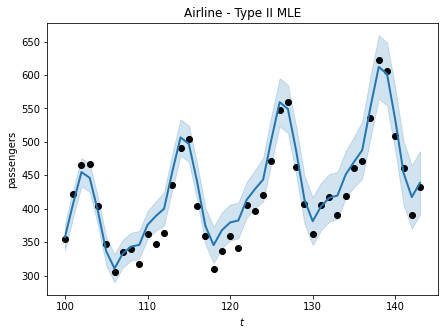

In [ ]:
# inference
mean, var, samples = execute_gp_inference(mle_model, X_air[train_air_split:].reshape(-1, 1), num_samples=10)

## plot
plt.figure(figsize=(7, 5))
# plot predictions
plt.plot(X_air[train_air_split:], mean, color='C0', lw=2)
plt.fill_between(
    X_air[train_air_split:].flatten(),
    mean[:, 0] - 2 * np.sqrt(var[:, 0]),
    mean[:, 0] + 2 * np.sqrt(var[:, 0]),
    color="C0",
    alpha=0.2,
)

# plot test data
plt.scatter(X_air[train_air_split:], y_air[train_air_split:], color='black')

plt.xlabel("$t$")
plt.ylabel("passengers")
plt.title('Airline - Type II MLE')
plt.savefig('airline_mle.pdf', bbox_inches='tight')
rms = mean_squared_error(mean.numpy().flatten(), y_air[train_air_split:], squared=False)
print(rms)
print(mle_model.log_marginal_likelihood().numpy())

plt.show()

### Type-II MAP
---

In [ ]:
## TIGHT PRIORS ##
# defining kernel
k_1 = gpflow.kernels.SquaredExponential()
k_2 = gpflow.kernels.Periodic(gpflow.kernels.SquaredExponential())
k_3 = gpflow.kernels.SquaredExponential()
k_4 = gpflow.kernels.White()
k_1.variance = k_3.variance
k_1.lengthscales = k_3.lengthscales

## since Airline data is sparse, several of the hyperparameters are weakly identified ton constrain inference to reasonable range
# they had a tighter normal prior around the ML-II estimates and Gamma(2, 0.1) priors for the noise 
prior_var = 0.5
# SE priors
k_1.variance.prior = tfp.distributions.Normal(to_default_float(mle_model.kernel.kernels[0].kernels[0].variance), to_default_float(prior_var))
k_1.lengthscales.prior = tfp.distributions.Normal(to_default_float(mle_model.kernel.kernels[0].kernels[0].lengthscales), to_default_float(prior_var))
# PER priors
k_2.base_kernel.variance.prior = tfp.distributions.Normal(to_default_float(mle_model.kernel.kernels[0].kernels[1].base_kernel.variance), to_default_float(prior_var))
k_2.base_kernel.lengthscales.prior = tfp.distributions.Normal(to_default_float(mle_model.kernel.kernels[0].kernels[1].base_kernel.lengthscales), to_default_float(prior_var))
k_2.period.prior = tfp.distributions.Normal(to_default_float(mle_model.kernel.kernels[0].kernels[1].period), to_default_float(prior_var))
# SE 2 priors
k_3.variance.prior = tfp.distributions.Normal(to_default_float(mle_model.kernel.kernels[1].variance), to_default_float(prior_var))
k_3.lengthscales.prior = tfp.distributions.Normal(to_default_float(mle_model.kernel.kernels[1].lengthscales), to_default_float(prior_var))
# Noise
# k_4.variance.prior = tfp.distributions.Gamma(to_default_float(2), to_default_float(0.1))
k_4.variance.prior = tfp.distributions.Normal(to_default_float(mle_model.kernel.kernels[2].variance), to_default_float(prior_var))

# composite
k_air_priors = k_1 * k_2 + k_3 + k_4

In [ ]:
## VAGUE PRIORS ##
# defining kernel
k_1 = gpflow.kernels.SquaredExponential()
k_2 = gpflow.kernels.Periodic(gpflow.kernels.SquaredExponential())
k_3 = gpflow.kernels.SquaredExponential()
k_4 = gpflow.kernels.White()
k_1.variance = k_3.variance
k_1.lengthscales = k_3.lengthscales

## since Airline data is sparse, several of the hyperparameters are weakly identified ton constrain inference to reasonable range
# they had a tighter normal prior around the ML-II estimates and Gamma(2, 0.1) priors for the noise 
prior_var = 100.0
# SE priors
k_1.variance.prior = tfp.distributions.Normal(to_default_float(0), to_default_float(prior_var))
k_1.lengthscales.prior = tfp.distributions.Normal(to_default_float(0), to_default_float(prior_var))
# PER priors
k_2.base_kernel.variance.prior = tfp.distributions.Normal(to_default_float(0), to_default_float(prior_var))
k_2.base_kernel.lengthscales.prior = tfp.distributions.Normal(to_default_float(0), to_default_float(prior_var))
k_2.period.prior = tfp.distributions.Normal(to_default_float(0), to_default_float(prior_var))
# SE 2 priors
k_3.variance.prior = tfp.distributions.Normal(to_default_float(0), to_default_float(prior_var))
k_3.lengthscales.prior = tfp.distributions.Normal(to_default_float(0), to_default_float(prior_var))
# Noise
# k_4.variance.prior = tfp.distributions.Gamma(to_default_float(2), to_default_float(0.1))
k_4.variance.prior = tfp.distributions.Normal(to_default_float(0), to_default_float(prior_var))

# composite
k_air_priors = k_1 * k_2 + k_3 + k_4

In [ ]:
# defining the model
map_model = gpflow.models.GPR((X_air[:train_air_split].reshape(-1, 1), y_air[:train_air_split].reshape(-1, 1)), kernel=k_air_priors)

# map_model.likelihood.variance.assign(1.0)
# gpflow.set_trainable(map_model.likelihood.variance, False)
map_model.likelihood.variance.prior = tfp.distributions.Gamma(to_default_float(2), to_default_float(0.1))
# map_model.likelihood.variance.prior = tfp.distributions.Normal(to_default_float(mle_model.likelihood.variance), to_default_float(prior_var))

# GPflow maximizes the log marginal likelihood by minimizing the training loss
# docs: https://gpflow.readthedocs.io/en/master/notebooks/basics/regression.html
# note: likelihood.variance is the noise variance of the Gaussian white noise model
opt = gpflow.optimizers.Scipy()
opt.minimize(map_model.training_loss, variables=map_model.trainable_variables, options=dict(maxiter=1000))
print_summary(map_model)

╒═══════════════════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════╕
│ name                                                      │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │      value │
╞═══════════════════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════╡
│ GPR.kernel.kernels[0].kernels[0].variance                 │ Parameter │ Softplus         │ Normal  │ True        │ ()      │ float64 │ 187.429    │
│ GPR.kernel.kernels[1].variance                            │           │                  │         │             │         │         │            │
├───────────────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ GPR.kernel.kernels[0].kernels[0].lengthscales             │ Parameter │ Softplus         │ Normal 

32.78859626518219
-447.1989611587734


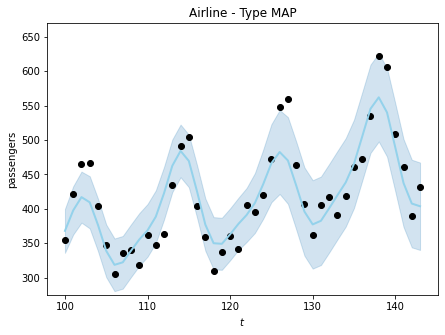

In [ ]:
# inference
mean, var, samples = execute_gp_inference(map_model, X_air[train_air_split:].reshape(-1, 1), num_samples=10)

## plot
plt.figure(figsize=(7, 5))
# plot predictions
plt.plot(X_air[train_air_split:], mean, "", color='#94d2eb', lw=2)
plt.fill_between(
    X_air[train_air_split:].flatten(),
    mean[:, 0] - 2 * np.sqrt(var[:, 0]),
    mean[:, 0] + 2 * np.sqrt(var[:, 0]),
    color="C0",
    alpha=0.2,
)

# plot test data
plt.scatter(X_air[train_air_split:], y_air[train_air_split:], color='black')

plt.title('Airline - Type MAP')
plt.xlabel("$t$")
plt.ylabel("passengers")
rms = mean_squared_error(mean.numpy().flatten(), y_air[train_air_split:], squared=False)
print(rms)
print(map_model.log_marginal_likelihood().numpy())
plt.ylim(275, 670)
plt.savefig('airline_map_vague.pdf', bbox_inches='tight')
plt.show()

### Fully-Bayesian Approach
---

In [ ]:
# defining kernel
k_1 = gpflow.kernels.SquaredExponential()
k_2 = gpflow.kernels.Periodic(gpflow.kernels.SquaredExponential())
k_3 = gpflow.kernels.SquaredExponential()
k_4 = gpflow.kernels.White()
k_1.variance = k_3.variance
k_1.lengthscales = k_3.lengthscales
k_air_full = k_1 * k_2 + k_3 + k_4

# defining the model
full_model = gpflow.models.GPR((X_air[:train_air_split].reshape(-1, 1), y_air[:train_air_split].reshape(-1, 1)), kernel=k_air_full)

# full_model.likelihood.variance.assign(2.0)
# gpflow.set_trainable(full_model.likelihood.variance, False)

# GPflow maximizes the log marginal likelihood by minimizing the training loss
# docs: https://gpflow.readthedocs.io/en/master/notebooks/basics/regression.html
# note: likelihood.variance is the noise variance of the Gaussian white noise model
opt = gpflow.optimizers.Scipy()
opt.minimize(full_model.training_loss, variables=full_model.trainable_variables, options=dict(maxiter=100))
print_summary(full_model)

╒═══════════════════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════╕
│ name                                                      │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │      value │
╞═══════════════════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════╡
│ GPR.kernel.kernels[0].kernels[0].variance                 │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 320.865    │
│ GPR.kernel.kernels[1].variance                            │           │                  │         │             │         │         │            │
├───────────────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ GPR.kernel.kernels[0].kernels[0].lengthscales             │ Parameter │ Softplus         │        

In [ ]:
prior_var = 0.5
full_model.kernel.kernels[0].kernels[0].variance.prior = tfp.distributions.Normal(to_default_float(full_model.kernel.kernels[0].kernels[0].variance), to_default_float(prior_var))
full_model.kernel.kernels[0].kernels[0].lengthscales.prior = tfp.distributions.Normal(to_default_float(full_model.kernel.kernels[0].kernels[0].lengthscales), to_default_float(prior_var))
full_model.kernel.kernels[0].kernels[1].base_kernel.variance.prior = tfp.distributions.Normal(to_default_float(full_model.kernel.kernels[0].kernels[1].base_kernel.variance), to_default_float(prior_var))
full_model.kernel.kernels[0].kernels[1].base_kernel.lengthscales.prior = tfp.distributions.Normal(to_default_float(full_model.kernel.kernels[0].kernels[1].base_kernel.lengthscales), to_default_float(prior_var))
full_model.kernel.kernels[0].kernels[1].period.prior = tfp.distributions.Normal(to_default_float(full_model.kernel.kernels[0].kernels[1].period), to_default_float(prior_var))
full_model.kernel.kernels[1].variance.prior = tfp.distributions.Normal(to_default_float(full_model.kernel.kernels[1].variance), to_default_float(prior_var))
full_model.kernel.kernels[1].lengthscales.prior = tfp.distributions.Normal(to_default_float(full_model.kernel.kernels[1].lengthscales), to_default_float(prior_var))
# full_model.kernel.kernels[2].variance.prior = tfp.distributions.Gamma(to_default_float(2), to_default_float(0.1))
# full_model.likelihood.variance.prior = tfp.distributions.Gamma(to_default_float(2), to_default_float(0.1))
full_model.kernel.kernels[2].variance.prior = tfp.distributions.Normal(to_default_float(full_model.kernel.kernels[2].variance), to_default_float(prior_var))
full_model.likelihood.variance.prior = tfp.distributions.Gamma(to_default_float(2), to_default_float(0.1))

In [ ]:
prior_var = 100.0
full_model.kernel.kernels[0].kernels[0].variance.prior = tfp.distributions.Normal(to_default_float(0), to_default_float(prior_var))
full_model.kernel.kernels[0].kernels[0].lengthscales.prior = tfp.distributions.Normal(to_default_float(0), to_default_float(prior_var))
full_model.kernel.kernels[0].kernels[1].base_kernel.variance.prior = tfp.distributions.Normal(to_default_float(0), to_default_float(prior_var))
full_model.kernel.kernels[0].kernels[1].base_kernel.lengthscales.prior = tfp.distributions.Normal(to_default_float(0), to_default_float(prior_var))
full_model.kernel.kernels[0].kernels[1].period.prior = tfp.distributions.Normal(to_default_float(0), to_default_float(prior_var))
full_model.kernel.kernels[1].variance.prior = tfp.distributions.Normal(to_default_float(0), to_default_float(prior_var))
full_model.kernel.kernels[1].lengthscales.prior = tfp.distributions.Normal(to_default_float(0), to_default_float(prior_var))
# full_model.kernel.kernels[2].variance.prior = tfp.distributions.Gamma(to_default_float(2), to_default_float(0.1))
# full_model.likelihood.variance.prior = tfp.distributions.Gamma(to_default_float(2), to_default_float(0.1))
full_model.kernel.kernels[2].variance.prior = tfp.distributions.Normal(to_default_float(0), to_default_float(prior_var))
full_model.likelihood.variance.prior = tfp.distributions.Gamma(to_default_float(2), to_default_float(0.1))

In [ ]:
print_summary(full_model)

╒═══════════════════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════╕
│ name                                                      │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │      value │
╞═══════════════════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════╡
│ GPR.kernel.kernels[0].kernels[0].variance                 │ Parameter │ Softplus         │ Normal  │ True        │ ()      │ float64 │ 320.865    │
│ GPR.kernel.kernels[1].variance                            │           │                  │         │             │         │         │            │
├───────────────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ GPR.kernel.kernels[0].kernels[0].lengthscales             │ Parameter │ Softplus         │ Normal 

In [ ]:
num_burnin_steps = ci_niter(500)
num_samples = ci_niter(1000)

# Note that here we need model.trainable_parameters, not trainable_variables - only parameters can have priors!
hmc_helper = gpflow.optimizers.SamplingHelper(
    full_model.log_posterior_density, full_model.trainable_parameters
)

hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=hmc_helper.target_log_prob_fn, num_leapfrog_steps=10, step_size=0.01
)
adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    hmc, num_adaptation_steps=10, target_accept_prob=f64(0.75), adaptation_rate=0.1
)


@tf.function
def run_chain_fn():
    return tfp.mcmc.sample_chain(
        num_results=num_samples,
        num_burnin_steps=num_burnin_steps,
        current_state=hmc_helper.current_state,
        kernel=adaptive_hmc,
        trace_fn=lambda _, pkr: pkr.inner_results.is_accepted,
    )


samples, traces = run_chain_fn()

In [ ]:
samples, traces = run_chain_fn()
# samples, traces = run_chain_fn()

In [ ]:
print_summary(full_model)

╒═══════════════════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════╕
│ name                                                      │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │     value │
╞═══════════════════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════╡
│ GPR.kernel.kernels[0].kernels[0].variance                 │ Parameter │ Softplus         │ Normal  │ True        │ ()      │ float64 │ 342.849   │
│ GPR.kernel.kernels[1].variance                            │           │                  │         │             │         │         │           │
├───────────────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.kernel.kernels[0].kernels[0].lengthscales             │ Parameter │ Softplus         │ Normal  │ Tru

-416.45425957664895
21.410220699624798


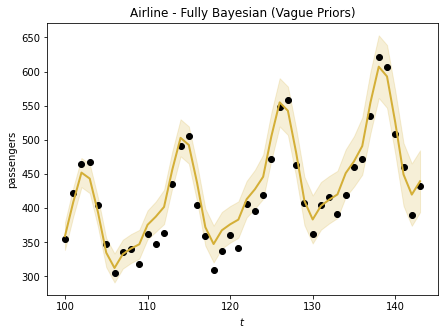

In [ ]:
## plot
plt.figure(figsize=(7, 5))

tf.random.set_seed(1)  # for reproducibility
# for i in range(0, num_samples, 20):
#     for var, var_samples in zip(hmc_helper.current_state, samples):
#         var.assign(var_samples[i])
#     f = full_model.predict_f_samples(X_air[train_air_split:], 100)
#     plt.plot(X_air[train_air_split:], f[0, :, :], "C0", lw=2, alpha=0.3)

mean, var = full_model.predict_f(X_air[train_air_split:])

# plot predictions
plt.plot(X_air[train_air_split:], mean, "", color='#d4af37', lw=2)
plt.fill_between(
    X_air[train_air_split:].flatten(),
    mean[:, 0] - 2 * np.sqrt(var[:, 0]),
    mean[:, 0] + 2 * np.sqrt(var[:, 0]),
    color='#d4af37',
    alpha=0.2,
)

# plot test data
plt.scatter(X_air[train_air_split:], y_air[train_air_split:], color='black')

plt.title('Airline - Fully Bayesian (Vague Priors)')
# plt.title('Airline - Fully Bayesian')
plt.xlabel("$t$")
plt.ylabel("passengers")
plt.savefig('airline_fully_bayes_vague.pdf', bbox_inches='tight')
rms = mean_squared_error(mean.numpy().flatten(), y_air[train_air_split:], squared=False)
print(full_model.log_marginal_likelihood().numpy())
print(rms)

plt.show()

## Wine Data Set
---

In [ ]:
# pulling the dataset
wine_df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/winequality-red.csv')

In [ ]:
wine_df

,7.4,0.7,0,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
0,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
1,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
2,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
3,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
4,7.4,0.660,0.00,1.8,0.075,13.0,40.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1593,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1594,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1595,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1596,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [ ]:
# parse data set
X_wine = wine_df.to_numpy()[:,:-1]
y_wine = np.array(wine_df[wine_df.columns[-1]], dtype=float)
n = len(X_wine)

# train split and test split
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
train_idx, test_idx = sklearn.model_selection.train_test_split(range(n), test_size=0.5, random_state=1)
X_wine_train = X_wine[train_idx]
y_wine_train = y_wine[train_idx]
X_wine_test = X_wine[test_idx]
y_wine_test = y_wine[test_idx]

In [ ]:
# defining SE-ARD kernel
# https://gpflow.readthedocs.io/en/master/notebooks/basics/GPLVM.html?highlight=ARD%20kernel#Model-construction
latent_dim = X_wine.shape[1]
lengthscales = tf.convert_to_tensor([1.0] * latent_dim)
k_wine = gpflow.kernels.RBF(lengthscales=lengthscales)

In [ ]:
# defining the model
mle_model = gpflow.models.GPR((X_wine_train, y_wine_train), kernel=k_wine)

# GPflow maximizes the log marginal likelihood by minimizing the training loss
# docs: https://gpflow.readthedocs.io/en/master/notebooks/basics/regression.html
# note: likelihood.variance is the noise variance of the Gaussian white noise model
opt = gpflow.optimizers.Scipy()
opt.minimize(mle_model.training_loss, variables=mle_model.trainable_variables, options=dict(maxiter=100))
print_summary(mle_model)

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════════════════════════════════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                                         │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════════════════════════════════════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 6.573736484268311                             │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────────────────────────────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ (11,)   │ float64 │ [1098.59719049, 520.72102967, 492.47324128... │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼──

In [ ]:
X_wine_test

array([[ 8.8  ,  0.41 ,  0.64 , ...,  3.54 ,  0.66 , 10.5  ],
       [ 8.7  ,  0.63 ,  0.28 , ...,  3.26 ,  0.63 , 10.2  ],
       [12.5  ,  0.46 ,  0.49 , ...,  3.05 ,  0.57 ,  9.6  ],
       ...,
       [10.6  ,  1.025,  0.43 , ...,  3.06 ,  0.57 , 10.1  ],
       [ 7.6  ,  0.68 ,  0.02 , ...,  3.17 ,  1.08 ,  9.2  ],
       [ 6.   ,  0.5  ,  0.   , ...,  3.36 ,  0.45 ,  9.5  ]])

In [ ]:
## predict mean and variance of latent GP at test points
mean, var = mle_model.predict_y(X_wine_test)

## generate 100 samples from posterior
tf.random.set_seed(1)  # for reproducibility
# samples = mle_model.predict_f_samples(X_wine_test, 10)  # shape (10, 100, 1)

# log marginal likelihood
lml = mle_model.log_marginal_likelihood().numpy()

test_rmse = calculate_rmse(mean.numpy().flatten(), y_wine_test)

ValueError: ignored

In [ ]:
mean.numpy()

array([[6.00000387, 6.00000387, 5.00000322, ..., 5.00000322, 6.00000387,
        6.00000387],
       [6.0000254 , 6.0000254 , 5.00002116, ..., 5.00002116, 6.0000254 ,
        6.0000254 ],
       [6.00000472, 6.00000472, 5.00000394, ..., 5.00000394, 6.00000472,
        6.00000472],
       ...,
       [6.0000116 , 6.0000116 , 5.00000966, ..., 5.00000966, 6.0000116 ,
        6.0000116 ],
       [5.99998803, 5.99998803, 4.99999002, ..., 4.99999002, 5.99998803,
        5.99998803],
       [5.99998355, 5.99998355, 4.99998629, ..., 4.99998629, 5.99998355,
        5.99998355]])

In [ ]:
print("Log Marginal Likelihood: {}".format(lml))
print("Test RMSE: {}".format(test_rmse))

##### Pymc3 Version
---

In [ ]:
with pm.Model() as map_model:
    # Priors
    l_se = pm.Lognormal('l_se', mu=0, sigma=3)
    sig_ard = pm.Lognormal('sig_se', mu=0, sigma=3)
    # Periodic
    period = pm.Lognormal('per', 0, 3)
    l_per = pm.Lognormal('l_per', 0, 3)
    sig_per = pm.Lognormal('sig_per', 0, 3)
    # Rational Quadratic
    alpha = pm.Lognormal('alpha', 0, 3)
    l_rq = pm.Lognormal('l_rq', 0, 3)
    tau = pm.Lognormal('tau', 0, 3)

    # Complex Composite Kernel
    k_se = sig_ard ** 2 * pm.gp.cov.ExpQuad(1, ls=l_se)
    k_per = sig_per ** 2 * pm.gp.cov.Periodic(1, period=period, ls=l_per)
    k_RQ = tau * pm.gp.cov.RatQuad(1, alpha, l_rq)
    composite_cov = k_se + k_se * k_per + k_RQ + k_se

    gp = pm.gp.Marginal(cov_func=composite_cov)

    # White Noise
    sigma = pm.HalfCauchy("noise", beta=3)
    y_ = gp.marginal_likelihood("y", X=X[:200], y=y[:200], noise=sigma)

    # computing MAP
    mp = pm.find_MAP()

In [ ]:
mp

{'alpha': array(0.00010751),
 'alpha_log__': array(-9.13796115),
 'l_per': array(0.12918734),
 'l_per_log__': array(-2.04649169),
 'l_rq': array(0.00015263),
 'l_rq_log__': array(-8.78748227),
 'l_se': array(1.81528381),
 'l_se_log__': array(0.59624182),
 'noise': array(2.81279332),
 'noise_log__': array(1.03417805),
 'per': array(1.8642919),
 'per_log__': array(0.6228813),
 'sig_per': array(0.88695565),
 'sig_per_log__': array(-0.11996029),
 'sig_se': array(9.40778611),
 'sig_se_log__': array(2.24153766),
 'tau': array(0.0001162),
 'tau_log__': array(-9.06018557)}

In [ ]:
# add the GP conditional to the model, given the new X values
# ref: https://docs.pymc.io/api/inference.html
with map_model:
    f_pred = gp.conditional("f_pred", X)

    # To use the MAP values, you can just replace the trace with a length-1 list with `mp`
    pred_samples = pm.sample_posterior_predictive([mp], var_names=['f_pred'], samples=2000)

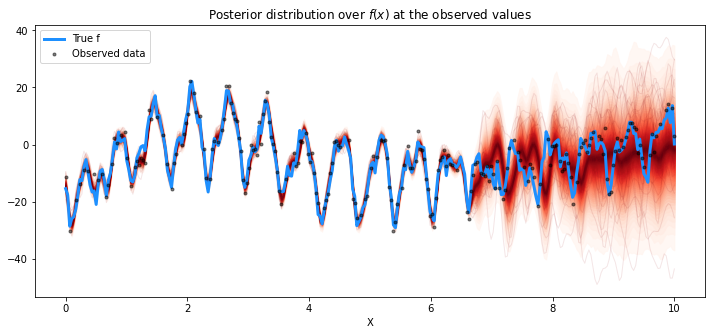

In [ ]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

plot_gp_dist(ax, pred_samples["f_pred"], X)

# plot the data and the true latent function
plt.plot(X, f_true, "dodgerblue", lw=3, label="True f")
plt.plot(X_train, y_train, "ok", ms=3, alpha=0.5, label="Observed data")

# axis labels and title
plt.xlabel("X")
# plt.ylim([-13, 13])
plt.title("Posterior distribution over $f(x)$ at the observed values")
plt.legend();

##### Pymc
---

In [ ]:
saved_hypers = {'alpha': 0.007539029042649064,
 'alpha_log__': -4.887661879438854,
 'l_per': 0.33415916950294083,
 'l_per_log__': -1.0961378441238707,
 'l_rq': 3.4540923996134123,
 'l_rq_log__': 1.2395597308471045,
 'l_se': 1.1301546286467294,
 'l_se_log__': 0.12235446287295741,
 'noise': 2.7933460099065,
 'noise_log__': 1.0272401639682696,
 'per': 0.6106667722542152,
 'per_log__': -0.4932038495108119,
 'sig_per': 2.0842331365902385,
 'sig_per_log__': 0.7344009873991546,
 'sig_se': 4.323808495559334,
 'sig_se_log__': 1.464136610072629,
 'tau': 4.961259019213394,
 'tau_log__': 1.6016595430451346}

In [ ]:
# defining kernel
# SE
k_1 = gpflow.kernels.SquaredExponential(variance=saved_hypers['l_se'], lengthscales=saved_hypers['sig_se'])
# SE fixed
set_trainable(k_1.variance, False)
set_trainable(k_1.lengthscales, False)
# PER 
k_2 = gpflow.kernels.Periodic(gpflow.kernels.SquaredExponential(variance=saved_hypers['sig_per'], lengthscales=saved_hypers['l_per']), period=saved_hypers['per'])
# PER fixed
set_trainable(k_2.period, False)
set_trainable(k_2.base_kernel.variance, False)
set_trainable(k_2.base_kernel.lengthscales, False)
# RQ
k_3 = gpflow.kernels.RationalQuadratic(variance=saved_hypers['tau'], lengthscales=saved_hypers['l_rq'], alpha=saved_hypers['alpha'])
# RQ priors
set_trainable(k_3.variance, False)
set_trainable(k_3.lengthscales, False)
set_trainable(k_3.alpha, False)

# composite
k_full = k_1 + k_1 * k_2 + k_3 + k_1

# defining the model
full_model = gpflow.models.GPR((X[:200].reshape(-1, 1), y[:200].reshape(-1, 1)), kernel=k_full)
full_model.likelihood.variance.assign(saved_hypers['noise'])
set_trainable(full_model.likelihood.variance, False)

print_summary(full_model)

╒═══════════════════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════╕
│ name                                                      │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │      value │
╞═══════════════════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════╡
│ GPR.kernel.kernels[0].variance                            │ Parameter │ Softplus         │         │ False       │ ()      │ float64 │ 1.13015    │
│ GPR.kernel.kernels[1].kernels[0].variance                 │           │                  │         │             │         │         │            │
│ GPR.kernel.kernels[3].variance                            │           │                  │         │             │         │         │            │
├───────────────────────────────────────────────────────────┼───────────┼──────────────────┼────────

In [ ]:
with pm.Model() as fully_bayes_model:
    # Priors
    l_se = pm.Lognormal('l_se', mu=0, sigma=3)
    sig_ard = pm.Lognormal('sig_se', mu=0, sigma=3)
    # Periodic
    period = pm.Lognormal('per', 0, 3)
    l_per = pm.Lognormal('l_per', 0, 3)
    sig_per = pm.Lognormal('sig_per', 0, 3)
    # Rational Quadratic
    alpha = pm.Lognormal('alpha', 0, 3)
    l_rq = pm.Lognormal('l_rq', 0, 3)
    tau = pm.Lognormal('tau', 0, 3)

    # Complex Composite Kernel
    k_se = sig_ard ** 2 * pm.gp.cov.ExpQuad(1, ls=l_se)
    k_per = sig_per ** 2 * pm.gp.cov.Periodic(1, period=period, ls=l_per)
    k_RQ = tau * pm.gp.cov.RatQuad(1, alpha, l_rq)
    composite_cov = k_se + k_se * k_per + k_RQ + k_se

    gp = pm.gp.Marginal(cov_func=composite_cov)

    # White Noise
    sigma = pm.HalfCauchy("noise", beta=3)
    y_ = gp.marginal_likelihood("y", X=X[:200], y=y[:200], noise=sigma)

In [ ]:
with fully_bayes_model:
    trace = pm.sample(2000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [noise, tau, l_rq, alpha, sig_per, l_per, per, sig_se, l_se]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 8175 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 352 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


In [ ]:
with fully_bayes_model:
    f_pred = gp.conditional("f_pred", X)

    # To use the MAP values, you can just replace the trace with a length-1 list with `mp`
    pred_samples = pm.sample_posterior_predictive([saved_hypers], var_names=['f_pred'], samples=2000)

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


In [ ]:
trace[-1]

{'alpha': 0.007539029042649064,
 'alpha_log__': -4.887661879438854,
 'l_per': 0.33415916950294083,
 'l_per_log__': -1.0961378441238707,
 'l_rq': 3.4540923996134123,
 'l_rq_log__': 1.2395597308471045,
 'l_se': 1.1301546286467294,
 'l_se_log__': 0.12235446287295741,
 'noise': 2.7933460099065,
 'noise_log__': 1.0272401639682696,
 'per': 0.6106667722542152,
 'per_log__': -0.4932038495108119,
 'sig_per': 2.0842331365902385,
 'sig_per_log__': 0.7344009873991546,
 'sig_se': 4.323808495559334,
 'sig_se_log__': 1.464136610072629,
 'tau': 4.961259019213394,
 'tau_log__': 1.6016595430451346}

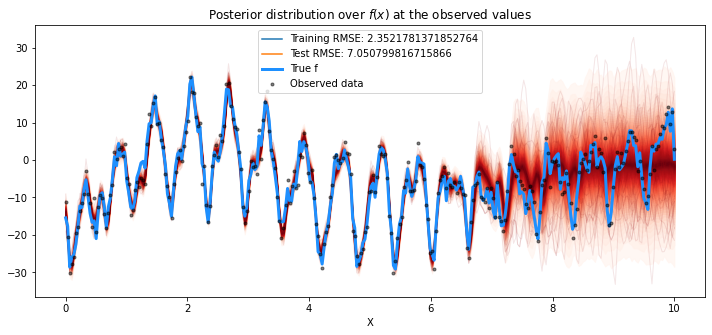

In [ ]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot preds
plot_gp_dist(ax, pred_samples["f_pred"], X)

# calculating rmse
# hard coded to 200 training and 100 test
fully_bayes_train_rmse = calculate_rmse(np.mean(pred_samples["f_pred"], axis = 0)[:200], y[:200])
fully_bayes_test_rmse = calculate_rmse(np.mean(pred_samples["f_pred"], axis = 0)[200:], y[200:])
plt.plot([], [], label="Training RMSE: {}".format(fully_bayes_train_rmse))
plt.plot([], [], label="Test RMSE: {}".format(fully_bayes_test_rmse))

# plot the data and the true latent function
plt.plot(X, f_true, "dodgerblue", lw=3, label="True f")
plt.plot(X, y, "ok", ms=3, alpha=0.5, label="Observed data")

# axis labels and title
plt.xlabel("X")
plt.title("Posterior distribution over $f(x)$ at the observed values")
plt.legend();

In [ ]:
# pulling the dataset
airline_df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv')
# parse data set
X_air = np.array(airline_df.index, dtype=float).reshape(-1, 1)
y_air = np.array(airline_df['Passengers'], dtype=float)
months = np.array(airline_df['Month'])

# train split
train_air_split = 100

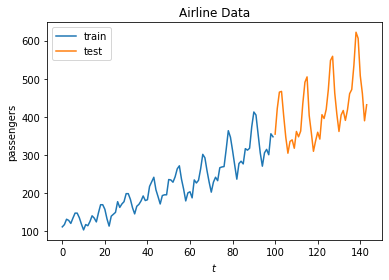

In [ ]:
# plot airline data
# plt.plot(X_air[train_air_split:], y_air[train_air_split:], label="airline data")
plt.plot(X_air[:train_air_split], y_air[:train_air_split], label="train")
plt.plot(X_air[train_air_split:], y_air[train_air_split:], label="test")
plt.xlabel("$t$")
plt.ylabel("passengers")
plt.title("Airline Data")
plt.legend(loc='best')
# plt.savefig('airline_data.pdf', bbox_inches='tight')

plt.show()

In [ ]:
# defining kernel
# note: Airline data is sparse and needs to be intialized to reasonable values first
k_1 = gpflow.kernels.SquaredExponential(variance=320.0, lengthscales=180.00)
k_2 = gpflow.kernels.Periodic(gpflow.kernels.SquaredExponential(variance=365, lengthscales=0.8), period=12.0)
k_3 = gpflow.kernels.SquaredExponential(variance=320.0, lengthscales=180.0)
k_4 = gpflow.kernels.White()
k_1.variance = k_3.variance
k_1.lengthscales = k_3.lengthscales
k_air = k_1 * k_2 + k_3 + k_4

## $CO_2$ Data Set
---

In [ ]:
# pulling the dataset
# co2_df = pd.read_csv('co2_mm_mlo.csv')
co2_df = pd.read_csv('https://raw.githubusercontent.com/datasets/co2-ppm/master/data/co2-mm-mlo.csv')
# delete unreasonable/malformed data
co2_df = co2_df[co2_df.Average > 0]

In [ ]:
co2_df

,Date,Decimal Date,Average,Interpolated,Trend,Number of Days
0,1958-03-01,1958.208,315.71,315.71,314.62,-1
1,1958-04-01,1958.292,317.45,317.45,315.29,-1
2,1958-05-01,1958.375,317.50,317.50,314.71,-1
4,1958-07-01,1958.542,315.86,315.86,314.98,-1
5,1958-08-01,1958.625,314.93,314.93,315.94,-1
...,...,...,...,...,...,...
701,2016-08-01,2016.625,402.25,402.25,404.09,23
702,2016-09-01,2016.708,401.03,401.03,404.52,24
703,2016-10-01,2016.792,401.57,401.57,404.93,29
704,2016-11-01,2016.875,403.53,403.53,405.57,27


In [ ]:
# parse data set
X_co = np.arange(len(co2_df.index), dtype=float).reshape(-1, 1)
y_co = np.array(co2_df['Average'], dtype=float).reshape(-1, 1)
dates = np.array(co2_df['Decimal Date'])

# train split
train_co_split = 545
# training
X_co_train = X_co[:train_co_split]
y_co_train = y_co[:train_co_split]
X_co_forecast = X_co[train_co_split:]
y_co_forecast = y_co[train_co_split:]

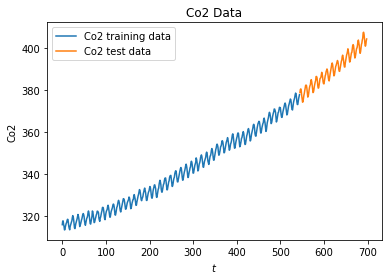

In [ ]:
# plot test data
plt.plot(X_co_train, y_co_train, label="Co2 training data")
plt.plot(X_co_forecast, y_co_forecast, label="Co2 test data")
plt.xlabel("$t$")
plt.ylabel("Co2")
plt.title("Co2 Data")
plt.legend(loc='best')

plt.show()

### Type-II MLE
---

In [ ]:
k1 = gpflow.kernels.SquaredExponential(variance=1.0, lengthscales=1.0)
k2 = gpflow.kernels.SquaredExponential(variance=1.0, lengthscales=1.0) 
k3 = gpflow.kernels.Periodic(gpflow.kernels.SquaredExponential(variance=1.0, lengthscales=1.0))
k_rq = gpflow.kernels.RationalQuadratic()
k4 = gpflow.kernels.SquaredExponential(variance=1.0, lengthscales=1.0)
k_noise = gpflow.kernels.White()
k4.variance = k1.variance
k4.lengthscales = k1.lengthscales
# k4.variance = k2.variance
# k4.lengthscales = k2.lengthscales
kernel = k1 + k2 * k3 + k_rq + k4 + k_noise

m = gpflow.models.GPR((X_co_train, y_co_train), kernel=kernel)
m.likelihood.variance = k_noise.variance 
opt = gpflow.optimizers.Scipy()
opt.minimize(m.training_loss, variables=m.trainable_variables, options=dict(maxiter=1000))
print_summary(m)

╒═══════════════════════════════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════════╕
│ name                                                      │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │           value │
╞═══════════════════════════════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════════╡
│ GPR.kernel.kernels[0].variance                            │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │     92.6238     │
│ GPR.kernel.kernels[3].variance                            │           │             │         │             │         │         │                 │
├───────────────────────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────────┤
│ GPR.kernel.kernels[0].lengthscales                        │ Parameter │ Softplus    │         │ Tr

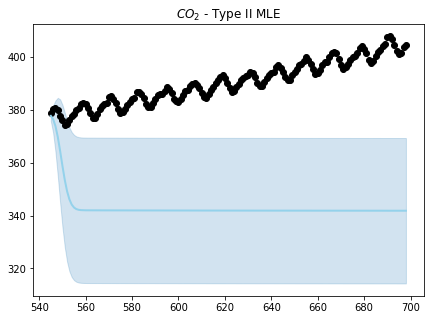

In [ ]:
# inference
mean, var, samples = execute_gp_inference(m, X_co_forecast, num_samples=1)

## plot
plt.figure(figsize=(7, 5))
# plot predictions
plt.plot(X_co_forecast, mean, "C0", lw=2, color='#94d2eb')
plt.fill_between(
    X_co_forecast.flatten(),
    mean[:, 0] - 2 * np.sqrt(var[:, 0]),
    mean[:, 0] + 2 * np.sqrt(var[:, 0]),
    color="C0",
    alpha=0.2,
)

plt.scatter(X_co_forecast, y_co_forecast, color='black')

plt.title('$CO_2$ - Type II MLE')
# plt.savefig(pdf_name, bbox_inches='tight')

plt.show()

In [ ]:
k1 = gpflow.kernels.SquaredExponential()
k2 = gpflow.kernels.SquaredExponential() 
k3 = gpflow.kernels.Periodic(gpflow.kernels.SquaredExponential())
k_rq = gpflow.kernels.RationalQuadratic()
k4 = gpflow.kernels.SquaredExponential()
# k1.variance = k2.variance
# k1.lengthscales = k2.lengthscales
kernel = k1 + k2 * k3 + k_rq

m = gpflow.models.GPR((X_co_train, y_co_train), kernel=kernel)
opt = gpflow.optimizers.Scipy()
opt.minimize(m.training_loss, variables=m.trainable_variables, options=dict(maxiter=1000))
print_summary(m)

╒═══════════════════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════════╕
│ name                                                      │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │          value │
╞═══════════════════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════════╡
│ GPR.kernel.kernels[0].variance                            │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │    0           │
├───────────────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────┤
│ GPR.kernel.kernels[0].lengthscales                        │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │   52.199       │
├───────────────────────────────────────────────────────────┼───────────┼───

1.3730812323277684


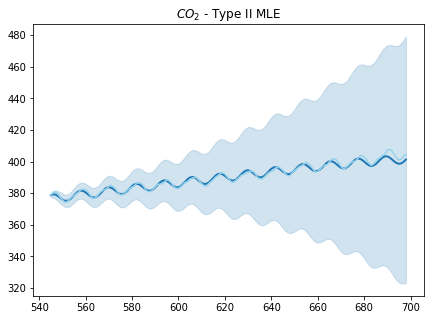

In [ ]:
# inference
mean, var, samples = execute_gp_inference(m, X_co_forecast, num_samples=10)

## plot
plt.figure(figsize=(7, 5))
# plot predictions
plt.plot(X_co_forecast, mean, "C0", lw=2)
plt.fill_between(
    X_co_forecast.flatten(),
    mean[:, 0] - 2 * np.sqrt(var[:, 0]),
    mean[:, 0] + 2 * np.sqrt(var[:, 0]),
    color="C0",
    alpha=0.2,
)

plt.plot(X_co_forecast, y_co_forecast, mew=0.5, color='#94d2eb')

plt.title('$CO_2$ - Type II MLE')
# plt.savefig(pdf_name, bbox_inches='tight')
rms = mean_squared_error(mean.numpy().flatten(), y_co_forecast, squared=False)
print(rms)

plt.show()

In [ ]:
m

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0
GPR.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,52.199
GPR.kernel.kernels[1].kernels[0].variance,Parameter,Softplus,,True,(),float64,570.097
GPR.kernel.kernels[1].kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,306.987
GPR.kernel.kernels[1].kernels[1].base_kernel.variance,Parameter,Softplus,,True,(),float64,570.097
GPR.kernel.kernels[1].kernels[1].base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,161.675
GPR.kernel.kernels[1].kernels[1].period,Parameter,Softplus,,True,(),float64,1.09185
GPR.kernel.kernels[2].variance,Parameter,Softplus,,True,(),float64,4453.98
GPR.kernel.kernels[2].lengthscales,Parameter,Softplus,,True,(),float64,90.9137
GPR.kernel.kernels[2].alpha,Parameter,Softplus,,True,(),float64,0.000103391


### Type-II MAP
---

In [ ]:
prior_var = 1.0
# SE
k_1 = gpflow.kernels.SquaredExponential()
# SE priors
k_1.variance.prior = tfp.distributions.Normal(to_default_float(m.kernel.kernels[0].variance), to_default_float(prior_var))
k_1.lengthscales.prior = tfp.distributions.Normal(to_default_float(m.kernel.kernels[0].lengthscales), to_default_float(prior_var))
# SE x PER
k_2 = gpflow.kernels.SquaredExponential() 
k_2.variance.prior = tfp.distributions.Normal(to_default_float(m.kernel.kernels[1].kernels[0].variance), to_default_float(prior_var))
k_2.lengthscales.prior = tfp.distributions.Normal(to_default_float(m.kernel.kernels[1].kernels[0].lengthscales), to_default_float(prior_var))
# PER 
k_per = gpflow.kernels.Periodic(gpflow.kernels.SquaredExponential())
# PER priors
k_per.base_kernel.variance.prior = tfp.distributions.Normal(to_default_float(m.kernel.kernels[1].kernels[1].base_kernel.variance), to_default_float(prior_var))
k_per.base_kernel.lengthscales.prior = tfp.distributions.Normal(to_default_float(m.kernel.kernels[1].kernels[1].base_kernel.lengthscales), to_default_float(prior_var))
k_per.period.prior = tfp.distributions.Normal(to_default_float(m.kernel.kernels[1].kernels[1].period), to_default_float(prior_var))
# RQ
k_rq = gpflow.kernels.RationalQuadratic()
# RQ priors
k_rq.variance.prior = tfp.distributions.Normal(to_default_float(m.kernel.kernels[2].variance), to_default_float(prior_var))
k_rq.lengthscales.prior = tfp.distributions.Normal(to_default_float(m.kernel.kernels[2].lengthscales), to_default_float(prior_var))
k_rq.alpha.prior = tfp.distributions.Normal(to_default_float(m.kernel.kernels[2].alpha), to_default_float(prior_var))
# another SE
# k_3 = gpflow.kernels.SquaredExponential() 
# k_3.variance.prior = tfp.distributions.Normal(to_default_float(0), to_default_float(3))
# k_3.lengthscales.prior = tfp.distributions.Normal(to_default_float(0), to_default_float(3))
# composite
k_map = k_1 + k_2 * k_per + k_rq

# defining the model
map_model = gpflow.models.GPR((X_co_train, y_co_train), kernel=k_map)
map_model.likelihood.variance.prior = tfp.distributions.Gamma(to_default_float(2), to_default_float(0.1))

# GPflow maximizes the log marginal likelihood by minimizing the training loss
# docs: https://gpflow.readthedocs.io/en/master/notebooks/basics/regression.html
# note: likelihood.variance is the noise variance of the Gaussian white noise model
opt = gpflow.optimizers.Scipy()
opt.minimize(map_model.training_loss, variables=map_model.trainable_variables, options=dict(maxiter=100))
print_summary(map_model)

╒═══════════════════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════════╕
│ name                                                      │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │         value │
╞═══════════════════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════════╡
│ GPR.kernel.kernels[0].variance                            │ Parameter │ Softplus         │ Normal  │ True        │ ()      │ float64 │   2.23366e-13 │
├───────────────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────┤
│ GPR.kernel.kernels[0].lengthscales                        │ Parameter │ Softplus         │ Normal  │ True        │ ()      │ float64 │   1.83531e-17 │
├───────────────────────────────────────────────────────────┼───────────┼─────────

70.40202300657718


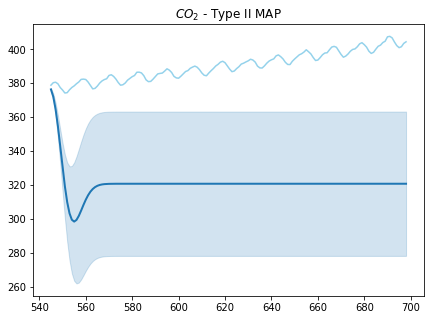

In [ ]:
# inference
mean, var, samples = execute_gp_inference(map_model, X_co_forecast, num_samples=10)

## plot
plt.figure(figsize=(7, 5))
# plot predictions
plt.plot(X_co_forecast, mean, "C0", lw=2)
plt.fill_between(
    X_co_forecast.flatten(),
    mean[:, 0] - 2 * np.sqrt(var[:, 0]),
    mean[:, 0] + 2 * np.sqrt(var[:, 0]),
    color="C0",
    alpha=0.2,
)

# plot training data
# plt.plot(X_co_train, y_co_train, mew=0.5, color='black')
# plot test data
plt.plot(X_co_forecast, y_co_forecast, mew=0.5, color='#94d2eb')

plt.title('$CO_2$ - Type II MAP')
# plt.savefig(pdf_name, bbox_inches='tight')
rms = mean_squared_error(mean.numpy().flatten(), y_co_forecast, squared=False)
print(rms)

plt.show()

Fully Bayesian Model
---

In [ ]:
k1 = gpflow.kernels.SquaredExponential()
k2 = gpflow.kernels.SquaredExponential() 
k3 = gpflow.kernels.Periodic(gpflow.kernels.SquaredExponential())
k_rq = gpflow.kernels.RationalQuadratic()
k4 = gpflow.kernels.SquaredExponential()
k1.variance = k2.variance
k1.lengthscales = k2.lengthscales
kernel = k1 + k2 * k3 + k_rq

full_model = gpflow.models.GPR((X_co_train, y_co_train), kernel=kernel)
opt = gpflow.optimizers.Scipy()
opt.minimize(full_model.training_loss, variables=full_model.trainable_variables, options=dict(maxiter=1000))
print_summary(full_model)

╒═══════════════════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════╕
│ name                                                      │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │       value │
╞═══════════════════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════╡
│ GPR.kernel.kernels[0].variance                            │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 175.26      │
│ GPR.kernel.kernels[1].kernels[0].variance                 │           │                  │         │             │         │         │             │
├───────────────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.kernel.kernels[0].lengthscales                        │ Parameter │ Softplus         │  

In [ ]:
prior_var = 3.0
# SE
full_model.kernel.kernels[0].variance.prior = tfp.distributions.Normal(to_default_float(full_model.kernel.kernels[0].variance), to_default_float(prior_var))
full_model.kernel.kernels[0].lengthscales.prior = tfp.distributions.Normal(to_default_float(full_model.kernel.kernels[0].lengthscales), to_default_float(3))
# SE x PER
full_model.kernel.kernels[1].kernels[0].variance.prior = tfp.distributions.Normal(to_default_float(full_model.kernel.kernels[1].kernels[0].variance), to_default_float(3))
full_model.kernel.kernels[1].kernels[0].lengthscales.prior = tfp.distributions.Normal(to_default_float(full_model.kernel.kernels[1].kernels[0].lengthscales), to_default_float(3))
# PER 
full_model.kernel.kernels[1].kernels[1].base_kernel.variance.prior = tfp.distributions.Normal(to_default_float(full_model.kernel.kernels[1].kernels[1].base_kernel.variance), to_default_float(3))
full_model.kernel.kernels[1].kernels[1].base_kernel.lengthscales.prior = tfp.distributions.Normal(to_default_float(full_model.kernel.kernels[1].kernels[1].base_kernel.lengthscales), to_default_float(3))
full_model.kernel.kernels[1].kernels[1].period.prior = tfp.distributions.Normal(to_default_float(full_model.kernel.kernels[1].kernels[1].period), to_default_float(3))
# RQ
full_model.kernel.kernels[2].variance.prior = tfp.distributions.Normal(to_default_float(full_model.kernel.kernels[2].variance), to_default_float(3))
full_model.kernel.kernels[2].lengthscales.prior = tfp.distributions.Normal(to_default_float(full_model.kernel.kernels[2].lengthscales), to_default_float(3))
full_model.kernel.kernels[2].alpha.prior = tfp.distributions.Normal(to_default_float(full_model.kernel.kernels[2].alpha), to_default_float(3))
full_model.likelihood.variance.prior = tfp.distributions.Gamma(to_default_float(2), to_default_float(0.1))

In [ ]:
print_summary(full_model)

╒═══════════════════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════╕
│ name                                                      │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │       value │
╞═══════════════════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════╡
│ GPR.kernel.kernels[0].variance                            │ Parameter │ Softplus         │ Normal  │ True        │ ()      │ float64 │ 175.26      │
│ GPR.kernel.kernels[1].kernels[0].variance                 │           │                  │         │             │         │         │             │
├───────────────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.kernel.kernels[0].lengthscales                        │ Parameter │ Softplus         │ N

In [ ]:
num_burnin_steps = ci_niter(500)
num_samples = ci_niter(1000)

# Note that here we need model.trainable_parameters, not trainable_variables - only parameters can have priors!
hmc_helper = gpflow.optimizers.SamplingHelper(
    full_model.log_posterior_density, full_model.trainable_parameters
)

hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=hmc_helper.target_log_prob_fn, num_leapfrog_steps=10, step_size=0.01
)
adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    hmc, num_adaptation_steps=10, target_accept_prob=f64(0.75), adaptation_rate=0.1
)


@tf.function
def run_chain_fn():
    return tfp.mcmc.sample_chain(
        num_results=num_samples,
        num_burnin_steps=num_burnin_steps,
        current_state=hmc_helper.current_state,
        kernel=adaptive_hmc,
        trace_fn=lambda _, pkr: pkr.inner_results.is_accepted,
    )


samples, traces = run_chain_fn()

InvalidArgumentError: ignored

In [ ]:
## plot
plt.figure(figsize=(7, 5))

tf.random.set_seed(1)  # for reproducibility

mean, var = full_model.predict_f(X_co_forecast)

# plot predictions
plt.plot(X_co_forecast, mean, "C0", color='#94d2eb', lw=2)
plt.fill_between(
    X_co_forecast.flatten(),
    mean[:, 0] - 2 * np.sqrt(var[:, 0]),
    mean[:, 0] + 2 * np.sqrt(var[:, 0]),
    color="C0",
    alpha=0.2,
)

# plot test data
plt.scatter(X_co_forecast, y_co_forecast, color='black')

plt.title('Airline - Fully Bayesian')
# plt.savefig(pdf_name, bbox_inches='tight')
rms = mean_squared_error(mean.numpy().flatten(), y_co_forecast, squared=False)
print(rms)

plt.show()

### Sklearn Approach
---

In [ ]:
import numpy as np

from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels \
    import RBF, WhiteKernel, RationalQuadratic, ExpSineSquared

print(__doc__)


def load_mauna_loa_atmospheric_co2():
    ml_data = fetch_openml(data_id=41187, as_frame=False)
    months = []
    ppmv_sums = []
    counts = []

    y = ml_data.data[:, 0]
    m = ml_data.data[:, 1]
    month_float = y + (m - 1) / 12
    ppmvs = ml_data.target

    for month, ppmv in zip(month_float, ppmvs):
        if not months or month != months[-1]:
            months.append(month)
            ppmv_sums.append(ppmv)
            counts.append(1)
        else:
            # aggregate monthly sum to produce average
            ppmv_sums[-1] += ppmv
            counts[-1] += 1

    months = np.asarray(months).reshape(-1, 1)
    avg_ppmvs = np.asarray(ppmv_sums) / counts
    return months, avg_ppmvs


X, y = load_mauna_loa_atmospheric_co2()

# Kernel with parameters given in GPML book
k1 = 66.0**2 * RBF(length_scale=67.0)  # long term smooth rising trend
k2 = 2.4**2 * RBF(length_scale=90.0) \
    * ExpSineSquared(length_scale=1.3, periodicity=1.0)  # seasonal component
# medium term irregularity
k3 = 0.66**2 \
    * RationalQuadratic(length_scale=1.2, alpha=0.78)
k4 = 0.18**2 * RBF(length_scale=0.134) \
    + WhiteKernel(noise_level=0.19**2)  # noise terms
kernel_gpml = k1 + k2 + k3 + k4

gp = GaussianProcessRegressor(kernel=kernel_gpml, alpha=0,
                              optimizer=None, normalize_y=True)
gp.fit(X, y)

print("GPML kernel: %s" % gp.kernel_)
print("Log-marginal-likelihood: %.3f"
      % gp.log_marginal_likelihood(gp.kernel_.theta))

# Kernel with optimized parameters
k1 = 50.0**2 * RBF(length_scale=50.0)  # long term smooth rising trend
k2 = 2.0**2 * RBF(length_scale=100.0) \
    * ExpSineSquared(length_scale=1.0, periodicity=1.0,
                     periodicity_bounds="fixed")  # seasonal component
# medium term irregularities
k3 = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)
k4 = 0.1**2 * RBF(length_scale=0.1) \
    + WhiteKernel(noise_level=0.1**2,
                  noise_level_bounds=(1e-5, np.inf))  # noise terms
kernel = k1 + k2 + k3 + k4

gp = GaussianProcessRegressor(kernel=kernel, alpha=0,
                              normalize_y=True)
gp.fit(X, y)

print("\nLearned kernel: %s" % gp.kernel_)
print("Log-marginal-likelihood: %.3f"
      % gp.log_marginal_likelihood(gp.kernel_.theta))

X_ = np.linspace(X.min(), X.max() + 30, 1000)[:, np.newaxis]
y_pred, y_std = gp.predict(X_, return_std=True)

# Illustration
plt.scatter(X, y, c='k')
plt.plot(X_, y_pred)
plt.fill_between(X_[:, 0], y_pred - y_std, y_pred + y_std,
                 alpha=0.5, color='k')
plt.xlim(X_.min(), X_.max())
plt.xlabel("Year")
plt.ylabel(r"CO$_2$ in ppm")
plt.title(r"Atmospheric CO$_2$ concentration at Mauna Loa")
plt.tight_layout()
plt.show()

### Autoregressive Approach
---

In [ ]:
## DIRECT FORECASTING STRATEGY ##
# iterate through time series test data
training_X = np.copy(X_co_train)
training_labels = np.copy(y_co_train)
mle_predictions = np.array([])

for test_point in X_co_forecast:
  # predict
  mean, _ = mle_model.predict_y(test_point.reshape(-1, 1))
  mean = mean.numpy().flatten()
  print(mean)
  # save prediction
  training_X = np.append(training_X, test_point).reshape(-1, 1)
  training_labels = np.append(training_labels, mean).reshape(-1, 1)
  # add prediction to training data
  mle_predictions = np.append(mle_predictions, mean).reshape(-1, 1)
  # retrain
  mle_model = gpflow.models.GPR((training_X.reshape(-1, 1), training_labels.reshape(-1, 1)), kernel=k_co2)
  opt = gpflow.optimizers.Scipy()
  opt.minimize(mle_model.training_loss, variables=mle_model.trainable_variables, options=dict(maxiter=100))
  print_summary(mle_model)

[378.62597889]
╒═══════════════════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════╕
│ name                                                      │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │       value │
╞═══════════════════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════╡
│ GPR.kernel.kernels[0].kernels[0].variance                 │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 84.8397     │
│ GPR.kernel.kernels[1].kernels[0].variance                 │           │                  │         │             │         │         │             │
│ GPR.kernel.kernels[2].variance                            │           │                  │         │             │         │         │             │
├───────────────────────────────────────────────────────────┼───────────┼──────

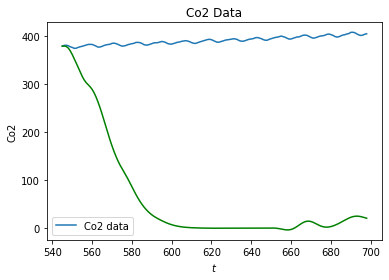

In [ ]:
# plot test data
plt.plot(X_co_forecast, y_co_forecast, label="Co2 data")
plt.plot(X_co_forecast, mle_predictions, color='green')
plt.xlabel("$t$")
plt.ylabel("Co2")
plt.title("Co2 Data")
plt.legend(loc='best')

plt.show()

In [ ]:
# defining the model
mle_model = gpflow.models.GPR((X_co_train, y_co_train), kernel=k_co2)

# GPflow maximizes the log marginal likelihood by minimizing the training loss
# docs: https://gpflow.readthedocs.io/en/master/notebooks/basics/regression.html
# note: likelihood.variance is the noise variance of the Gaussian white noise model
opt = gpflow.optimizers.Scipy()
opt.minimize(mle_model.training_loss, variables=mle_model.trainable_variables, options=dict(maxiter=100))
print_summary(mle_model)

╒═══════════════════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════════╕
│ name                                                      │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │         value │
╞═══════════════════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════════╡
│ GPR.kernel.kernels[0].kernels[0].variance                 │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 192.399       │
│ GPR.kernel.kernels[1].kernels[0].variance                 │           │                  │         │             │         │         │               │
│ GPR.kernel.kernels[2].variance                            │           │                  │         │             │         │         │               │
├───────────────────────────────────────────────────────────┼───────────┼─────────

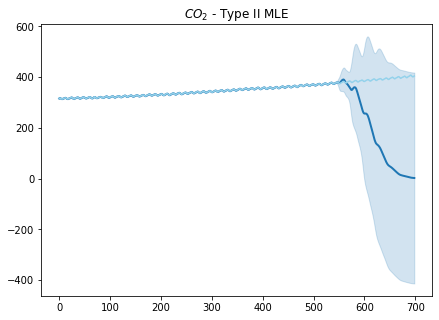

In [ ]:
# inference
mean, var, samples = execute_gp_inference(mle_model, X_co, num_samples=10)

## plot
plt.figure(figsize=(7, 5))
# plot predictions
plt.plot(X_co, mean, "C0", lw=2)
plt.fill_between(
    X_co.flatten(),
    mean[:, 0] - 2 * np.sqrt(var[:, 0]),
    mean[:, 0] + 2 * np.sqrt(var[:, 0]),
    color="C0",
    alpha=0.2,
)

# plot training data
# plt.plot(X_co_train, y_co_train, mew=0.5, color='black')
# plot test data
plt.plot(X_co, y_co, mew=0.5, color='#94d2eb')

plt.title('$CO_2$ - Type II MLE')

# plt.savefig(pdf_name, bbox_inches='tight')

plt.show()